In [2]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  

In [24]:
from pymongo import MongoClient
from pprint import pprint
from typing import List
from functools import reduce
from operator import add

# DB CONFIG
client = MongoClient('mongo', 27017)
db = client.music_db
COLLECTIONS = ['pop-songs', 'rock-songs']

def has_spotify(song):
    return song.get('spotify', {}).get('audio_features')


def update_collections(collection_names):
    all_songs = []
    for name in collection_names:
        collection = db[name]
        for song in collection.find():
            if has_spotify(song):
                song['genre'] = name
                song.update(song['spotify']['audio_features'])
                all_songs.append(song)
            
    return all_songs
        
songs_collections = update_collections(COLLECTIONS)

In [25]:
len(songs_collections)

3999

In [26]:
df = pd.DataFrame(songs_collections)
df = df.drop(columns=['_id', 'id', 'identifier', 'isNew', 'lastPos', 'peakPos', 'rank', 'weeks', 'track_href', 'type', 'uri', 'spotify', 'analysis_url'])
df.head()

acousticness               artist  danceability  duration_ms  energy  \
0         0.977     Khalid & Normani         0.738       219231   0.182   
1         0.892          Post Malone         0.680       203778   0.263   
2         0.981  5 Seconds Of Summer         0.552       233603   0.139   
3         0.982         Selena Gomez         0.400       228870   0.169   
4         0.207        Ariana Grande         0.327       190023   0.532   

       genre  instrumentalness  key  liveness  loudness  \
0  pop-songs             0.937    3    0.1140   -11.813   
1  pop-songs             0.000    1    0.1390   -15.722   
2  pop-songs             0.937    7    0.1000   -12.590   
3  pop-songs             0.954    6    0.1140   -12.988   
4  pop-songs             0.874    3    0.0888    -8.440   

                                              lyrics  mode  speechiness  \
0      {'error': 'Lyric no found, try again later.'}     0       0.0395   
1  {'result': {'artist': {'name': 'Post Malone'},...     0       0.9300   
2  {'result': {'artist': {'name': '5 Seconds of S...     0       0.0408   
3  {'result': {'artist': {'name': 'Selena Gomez'}...     1       0.0479   
4  {'result': {'artist': {'name': 'Ariana Grande'...     0       0.0397   

     tempo  time_signature           title  valence  
0  129.999               4       Love Lies   0.2790  
1   97.262               4      Better Now   0.6840  
2  169.628               3      Youngblood   0.1660  
3   95.995               4     Back To You   0.0794  
4  144.060               4  God Is A Woman   0.0546

In [27]:
STR_COLS = ['title', 'lyrics', 'artist']   # Remove columns with string as names

# Assign colum names to the dataset
names = list(df.columns.values)

# Read dataset to pandas dataframe
dataset_copy = df

## K MEANS CLASSIFICATION

In [28]:
dataset = dataset_copy.drop(columns=STR_COLS)
y = dataset['genre'].values
X = dataset.drop(columns='genre').values 

In [29]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)  

In [30]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

In [36]:
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=3)  
classifier.fit(X_train, y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [37]:
y_pred = classifier.predict(X_test)  

from sklearn.metrics import classification_report, confusion_matrix  

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  

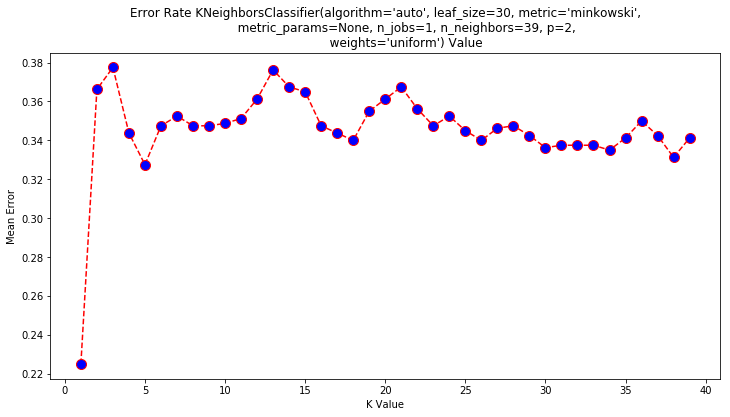

In [140]:
def error_graph(classifier, i_attribute: str, i_start=1, i_end=40):
    
    error = []
    i_att = {i_attribute: 0}
    
    
    # Calculating error for K values between 1 and 40
    for i in range(i_start, i_end):  
        i_att[i_attribute] = i
        clsfy = classifier(**i_att)
        clsfy.fit(X_train, y_train)
        pred_i = clsfy.predict(X_test)
        error.append(np.mean(pred_i != y_test))
    
    plt.figure(figsize=(12, 6))  
    plt.plot(range(i_start, i_end), error, color='red', linestyle='dashed', marker='o',  
             markerfacecolor='blue', markersize=10)
    plt.title(f'Error Rate {clsfy} Value')  
    plt.xlabel('K Value')  
    plt.ylabel('Mean Error')  

error_graph(KNeighborsClassifier, "n_neighbors")

In [141]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  

[[333 139]
 [ 99 229]]
             precision    recall  f1-score   support

  pop-songs       0.77      0.71      0.74       472
 rock-songs       0.62      0.70      0.66       328

avg / total       0.71      0.70      0.70       800



## DECISION TREE CLASSIFICATION 

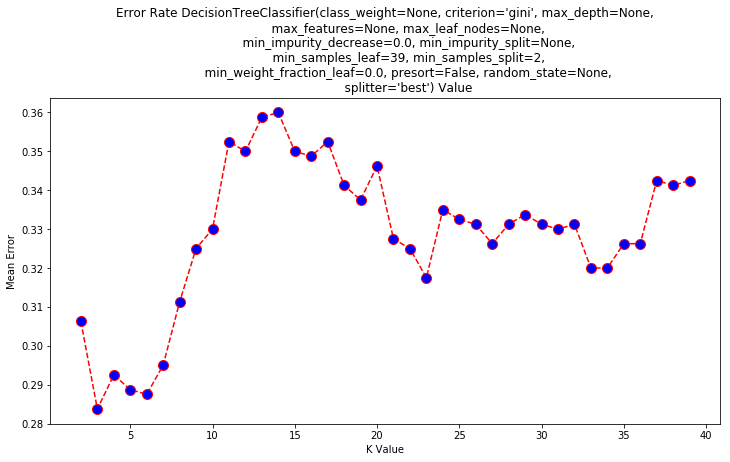

In [175]:
from functools import partial
error_graph(DecisionTreeClassifier, "min_samples_leaf", i_start=2, i_end=40)

In [176]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=3)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [177]:
y_pred = dtree.predict(X_test)  

In [178]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  

[[342 130]
 [ 92 236]]
             precision    recall  f1-score   support

  pop-songs       0.79      0.72      0.75       472
 rock-songs       0.64      0.72      0.68       328

avg / total       0.73      0.72      0.72       800



In [179]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

colums = list(dataset.columns.values)
colums.remove("genre")

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=colums)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decision_tree.png')
Image(graph.create_png())

In [180]:
# Bag of words
# TfIDF
# Length of lyrics
# Lyric emotion
# Song title